In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [51]:

with open("ckpts/sft_bios_new_llama7B/checkpoint_20000/hf_model/factscores_test_medium.json", "r") as f:
    factscores = json.load(f)

decisions = factscores["decisions"]

lines_all = []
correct_all = []
bio_idxs = []
for i, decision in enumerate(decisions):
    if decision is not None: 
        for atomic_fact in decision:
            lines_all.append(atomic_fact["atom"])
            correct_all.append(atomic_fact["is_supported"])
            bio_idxs.append(i)
    else:
        print("here")
lines_all = np.array(lines_all)
correct_all = np.array(correct_all)
bio_idxs = np.array(bio_idxs)
true_samples = np.where(correct_all == True)[0]
false_samples = np.where(correct_all == False)[0]

In [52]:
rm_path = "ckpts/rm2_atmoic_facts_llama7B/checkpoint_10000/hf_model/"
rm_gpt3pt5_path = "ckpts/rm2_atmoic_facts_gpt3pt5_llama7B/checkpoint_10000/hf_model/"
rm_50_50_path = "ckpts/rm_atmoic_facts_llama7B_50_50/checkpoint_10000/hf_model/"


rm_samples_preds = np.load(rm_path + "test_medium_samples_preds.npy")
rm_samples_preds = (rm_samples_preds == " Yes.")
rm_gpt3pt5_samples_preds = np.load(rm_gpt3pt5_path + "test_medium_samples_preds.npy")
rm_gpt3pt5_samples_preds = (rm_gpt3pt5_samples_preds == " Yes.")


rm_50_50_samples_preds = np.load(rm_50_50_path + "test_medium_samples_preds.npy")
rm_50_50_samples_preds = (rm_50_50_samples_preds == " Yes.")

In [53]:
len(rm_samples_preds)

15221

In [54]:
len(correct_all)

15221

In [55]:
len(decisions)

5000

In [56]:
real_rewards = []
rm_rewards = []
rm_gpt3pt5_rewards = []
rm_50_50_rewards = []

for i in range(len(decisions)):
    if decisions[i] is not None:
        fact_idxs = np.where(bio_idxs == i)[0]

        num_true = correct_all[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        real_rewards.append(2*num_true - 3*num_false)


        num_true = rm_samples_preds[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        rm_rewards.append(2*num_true - 3*num_false)

        num_true = rm_gpt3pt5_samples_preds[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        rm_gpt3pt5_rewards.append(2*num_true - 3*num_false)


        num_true = rm_50_50_samples_preds[fact_idxs].sum()
        num_false = len(fact_idxs) - num_true
        rm_50_50_rewards.append(2*num_true - 3*num_false)

In [58]:
real_rewards = np.array(real_rewards)
rm_rewards = np.array(rm_rewards)
rm_gpt3pt5_rewards = np.array(rm_gpt3pt5_rewards)
rm_50_50_rewards = np.array(rm_50_50_rewards)

In [71]:
num_entities  = np.load("num_pretrain_entities/bios_test_points_medium.npy")
num_entities_bins = np.percentile(num_entities[np.where(num_entities >= 0)[0]], [0, 75, 80, 85, 90, 95,100])
num_entities_bins = np.array([0, 200, 400, 600, 800, 1000, np.inf])*1.5


rm_real_diff = []
rm_real_diff_std = []
rm_gpt3pt5_real_diff = []
rm_gpt3pt5_real_diff_std = []
rm_50_50_diff = []
rm_50_50_diff_std = []

binned_real_rewards = []
binned_real_rewards_std = []
binned_rm_rewards = []
binned_rm_rewards_std = []
binned_rm_gpt3pt5_rewards = []
binned_rm_gpt3pt5_rewards_std = []
for i in range(len(num_entities_bins) - 1):
    idxs = np.where((num_entities >= num_entities_bins[i]) & (num_entities < num_entities_bins[i+1]))[0]
    rm_real_diff.append(((rm_rewards-real_rewards)[idxs]).mean())
    rm_real_diff_std.append(((rm_rewards-real_rewards)[idxs]).std())
    rm_gpt3pt5_real_diff.append(((rm_gpt3pt5_rewards-real_rewards)[idxs]).mean())
    rm_gpt3pt5_real_diff_std.append(((rm_gpt3pt5_rewards-real_rewards)[idxs]).std())
    rm_50_50_diff.append(((rm_50_50_rewards-real_rewards)[idxs]).mean())
    rm_50_50_diff_std.append(((rm_50_50_rewards-real_rewards)[idxs]).std())

    binned_real_rewards.append(real_rewards[idxs].mean())
    binned_rm_rewards.append(rm_rewards[idxs].mean())
    binned_rm_gpt3pt5_rewards.append(rm_gpt3pt5_rewards[idxs].mean())
    binned_real_rewards_std.append(real_rewards[idxs].std())
    binned_rm_rewards_std.append(rm_rewards[idxs].std())
    binned_rm_gpt3pt5_rewards_std.append(rm_gpt3pt5_rewards[idxs].std())


In [72]:
num_entities_bins

array([   0.,  300.,  600.,  900., 1200., 1500.,   inf])

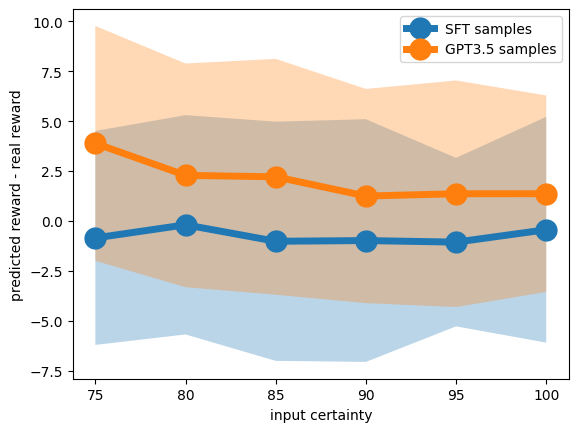

In [73]:
x = [75, 80, 85, 90, 95,  100]

plt.plot(x, rm_real_diff, "o-", label="SFT samples", markersize=15, linewidth=5)
plt.fill_between(x, np.array(rm_real_diff) - np.array(rm_real_diff_std), np.array(rm_real_diff) + np.array(rm_real_diff_std), alpha=0.3)
plt.plot(x,rm_gpt3pt5_real_diff, "o-", label="GPT3.5 samples", markersize=15, linewidth=5)
plt.fill_between(x, np.array(rm_gpt3pt5_real_diff) - np.array(rm_gpt3pt5_real_diff_std), np.array(rm_gpt3pt5_real_diff) + np.array(rm_gpt3pt5_real_diff_std), alpha=0.3)

# plt.plot(x,rm_50_50_diff, "o-", label="50 True-50 False")
# plt.fill_between(x, np.array(rm_50_50_diff) - np.array(rm_50_50_diff_std), np.array(rm_50_50_diff) + np.array(rm_50_50_diff_std), alpha=0.3)


plt.ylabel("predicted reward - real reward")
plt.xlabel("input certainty")

plt.legend()
# plt.ylim(-10, 10)

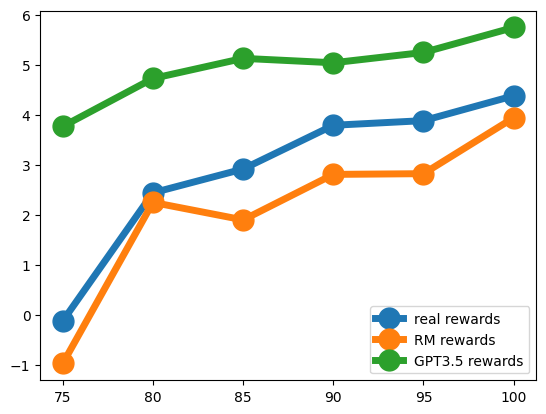

In [74]:
plt.plot(x,  np.array(binned_real_rewards), "o-", label="real rewards", markersize=15, linewidth=5)
# plt.fill_between(x, np.array(binned_real_rewards) - np.array(binned_real_rewards_std), np.array(binned_real_rewards) + np.array(binned_real_rewards_std), alpha=0.3)
plt.plot(x,  np.array(binned_rm_rewards), "o-", label="RM rewards", markersize=15, linewidth=5)
# plt.fill_between(x, np.array(binned_rm_rewards) - np.array(binned_rm_rewards_std), np.array(binned_rm_rewards) + np.array(binned_rm_rewards_std), alpha=0.3)
plt.plot(x,  np.array(binned_rm_gpt3pt5_rewards), "o-", label="GPT3.5 rewards", markersize=15, linewidth=5)
# plt.fill_between(x, np.array(binned_rm_gpt3pt5_rewards) - np.array(binned_rm_gpt3pt5_rewards_std), np.array(binned_rm_gpt3pt5_rewards) + np.array(binned_rm_gpt3pt5_rewards_std), alpha=0.3)

plt.legend()

In [75]:
num_entities = np.load('base_model_perplexities/bios_test_points_medium.npy')

In [19]:
len(rm_rewards)

5000